I have to do the following task to build this predictive model
1. Import libraries and dataset
2. Inspect and understanding the data
3. Feature engineering - transformation, inconsistencies removal, encoding the variables, Add or remove features, Scaling etc.
4. Data preparation - Check missing data, detect and remove outliers etc.
5. Train-Test split
6. Train the model using suitable ML algo.
7. Predict the results of test data
8. Evaluate metrices
9. Insights and Important factors
10. Save and load model from pickle file

# Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Import and Inspect the dataset

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


# Feature Engineering

Check for inconsistencies in the balances

In [5]:
df['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['balance_diff_dest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [6]:
inconsistent_orig = df[df['balance_diff_orig'] != 0]
inconsistent_dest = df[df['balance_diff_dest'] != 0]

print("Inconsistent origin balances rows are:", len(inconsistent_orig))
print("Inconsistent destination balances rows are:", len(inconsistent_dest))

Inconsistent origin balances rows are: 5922109
Inconsistent destination balances rows are: 4736674


Create a function to correct balances

In [7]:
def correct_balances(row):
    if row['type'] == 'CASH-OUT':
        # In CASH-OUT transaction, the sender's new balance should be oldbalanceOrg - amount
        if row['newbalanceOrig'] != row['oldbalanceOrg'] - row['amount']:
            row['newbalanceOrig'] = row['oldbalanceOrg'] - row['amount']
    
    elif row['type'] == 'CASH-IN':
        # In CASH-IN transaction, the recipient's new balance should be oldbalanceDest + amount
        if row['newbalanceDest'] != row['oldbalanceDest'] + row['amount']:
            row['newbalanceDest'] = row['oldbalanceDest'] + row['amount']
    
    elif row['type'] == 'TRANSFER':
        # In TRANSFER, both origin and destination balances are involved
        if row['newbalanceOrig'] != row['oldbalanceOrg'] - row['amount']:
            row['newbalanceOrig'] = row['oldbalanceOrg'] - row['amount']
        if row['newbalanceDest'] != row['oldbalanceDest'] + row['amount']:
            row['newbalanceDest'] = row['oldbalanceDest'] + row['amount']
    
    elif row['type'] == 'DEBIT':
        # In DEBIT transaction, treat it similar to CASH-OUT
        if row['newbalanceOrig'] != row['oldbalanceOrg'] - row['amount']:
            row['newbalanceOrig'] = row['oldbalanceOrg'] - row['amount']

    elif row['type'] == 'PAYMENT':
        # In PAYMENT, the payer's new balance should be oldbalanceOrg - amount
        if row['newbalanceOrig'] != row['oldbalanceOrg'] - row['amount']:
            row['newbalanceOrig'] = row['oldbalanceOrg'] - row['amount']
    
    return row

Apply the correction function to each row and check that inconsistencies are resolved or not;

In [8]:
df_corrected = df.apply(correct_balances, axis=1)

In [9]:
df_corrected = df_corrected.drop(['balance_diff_orig', 'balance_diff_dest'], axis=1)

In [10]:
df_corrected['balance_diff_orig'] = df_corrected['oldbalanceOrg'] - df_corrected['newbalanceOrig'] - df_corrected['amount']
df_corrected['balance_diff_dest'] = df_corrected['oldbalanceDest'] + df_corrected['amount'] - df_corrected['newbalanceDest']

print("Inconsistent origin balances after correction:", len(df_corrected[df_corrected['balance_diff_orig'] != 0]))
print("Inconsistent destination balances after correction:", len(df_corrected[df_corrected['balance_diff_dest'] != 0]))

Inconsistent origin balances after correction: 4243613
Inconsistent destination balances after correction: 4504305


Now, correct the 'isFraud' column based on above function 'correct_balances'

So create a function to transform "isFraud" column and apply correct results into it

In [11]:
def isFraud(row):
    if row['type'] == 'CASH-OUT' or row['type'] == 'TRANSFER':
        if row['newbalanceOrig'] == 0 and row['amount'] > 10000:  
            row['isFraud'] = 1
        else:
            row['isFraud'] = 0
    else:
        row['isFraud'] = 0  
    return row

df_corrected = df_corrected.apply(isFraud, axis=1)

In [12]:
df_corrected = df_corrected.drop(['balance_diff_orig', 'balance_diff_dest'], axis=1)
df_corrected.to_csv('Corrected_Fraud_Data.csv', index=False)

# Display the corrected dataset
df_corrected.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,181.0,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [13]:
df_corrected.sample(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2320970,188,PAYMENT,8170.22,C546508251,22404.15,14233.93,M1618947542,0.00,0.00,0,0
4195575,305,TRANSFER,4896784.77,C1916522101,0.00,-4896784.77,C1247684408,10485648.92,15382433.69,0,0
434601,18,CASH_IN,191659.37,C941203564,11186.00,202845.37,C79971626,0.00,0.00,0,0
4911924,349,TRANSFER,637465.93,C1233625765,100791.00,-536674.93,C1103130562,3492425.69,4129891.62,0,0
1122365,130,CASH_IN,112933.18,C2136423970,10808.00,123741.18,C2029730894,707121.37,594188.19,0,0
2901315,228,CASH_IN,19621.00,C1174027046,117.00,19738.00,C2117465900,0.00,0.00,0,0
1421347,139,PAYMENT,28419.84,C187368719,0.00,-28419.84,M1730844009,0.00,0.00,0,0
6099168,522,PAYMENT,9169.54,C1289031826,16624.00,7454.46,M795791022,0.00,0.00,0,0
4629920,329,CASH_OUT,62286.23,C1472663600,0.00,0.00,C2121083836,135571.57,197857.80,0,0
3204072,249,CASH_OUT,91861.78,C976157030,11035.00,0.00,C2020994335,268132.15,359993.92,0,0


In [14]:
# Check for missing values

print(df_corrected.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


Encoding the Categorical Variable 'type' field

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_corrected['type'] = le.fit_transform(df_corrected['type'])

In [16]:
df_corrected['type'].head()

0    3
1    3
2    4
3    1
4    3
Name: type, dtype: int64

# Outlier Detection and removal

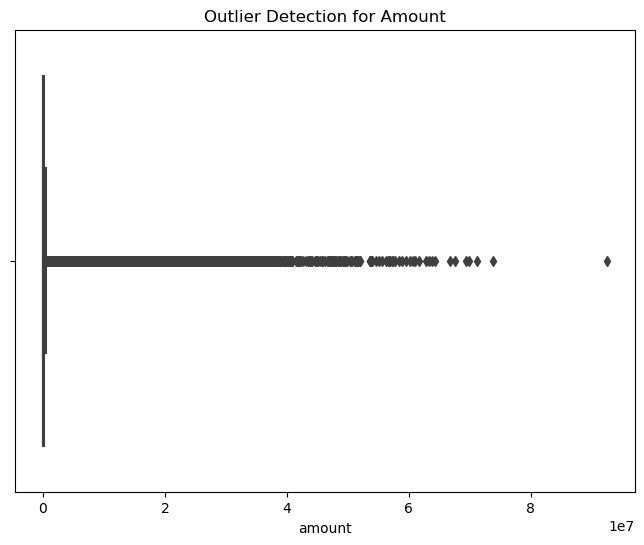

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['amount'])
plt.title('Outlier Detection for Amount')
plt.show()

This is 'IQR' method, used to remove outlier

In [18]:
Q1 = df_corrected['amount'].quantile(0.25)
Q3 = df_corrected['amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_corrected = df_corrected[(df_corrected['amount'] >= lower_bound) & (df_corrected['amount'] <= upper_bound)]

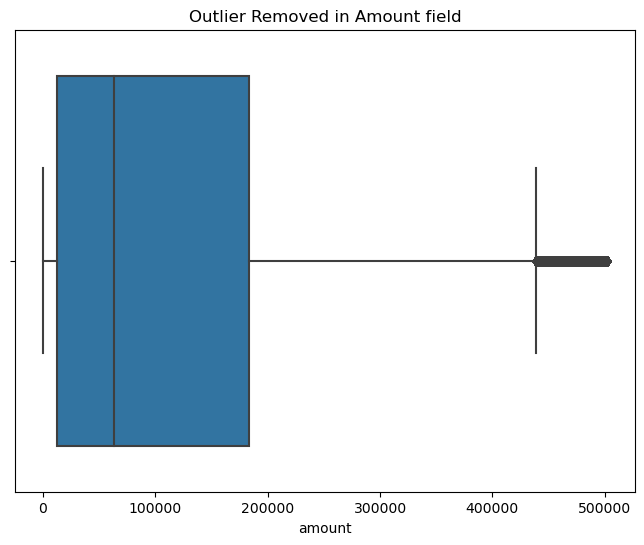

In [19]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_corrected['amount'])
plt.title('Outlier Removed in Amount field')
plt.show()

# Multicollinearity Check

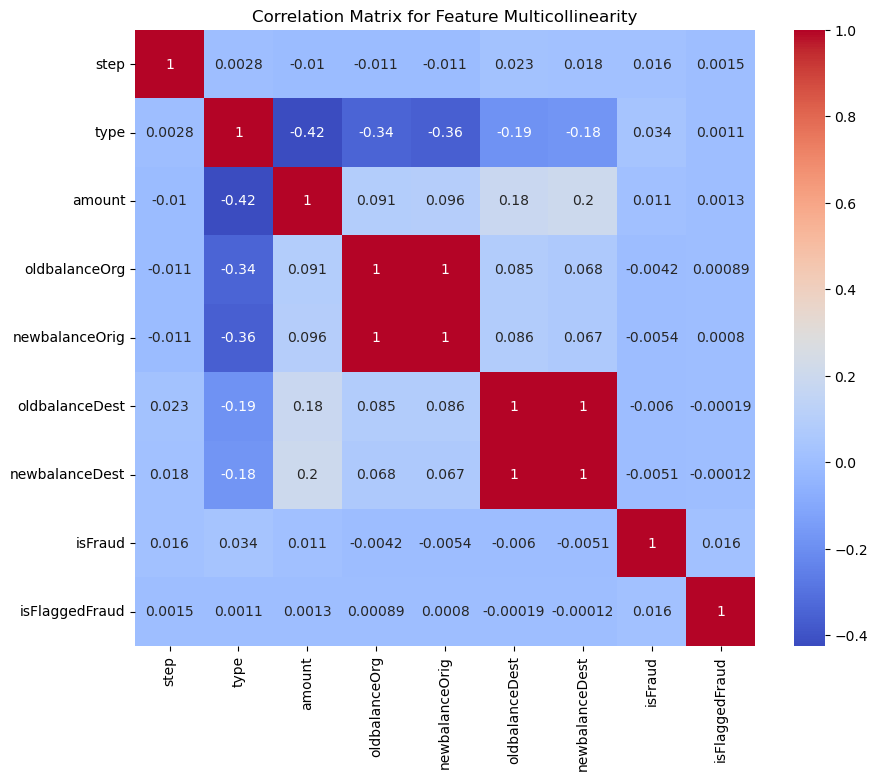

In [20]:
# Plot the heatmap to check the correlation between the features

corr_matrix = df_corrected.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Feature Multicollinearity')
plt.show()

Identify the input and target variables and select them

In [22]:
X = df_corrected[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type']]
y = df_corrected['isFraud']  # Target variable

# Train_test split

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
print(X_train.shape)
print(X_test.shape)

(4518406, 6)
(1506136, 6)


# Training the model using RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Predict the results and evaluate the metrices

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

y_pred = rfc.predict(X_test)

Confusion matrix returns that how many results are correctly predicted 

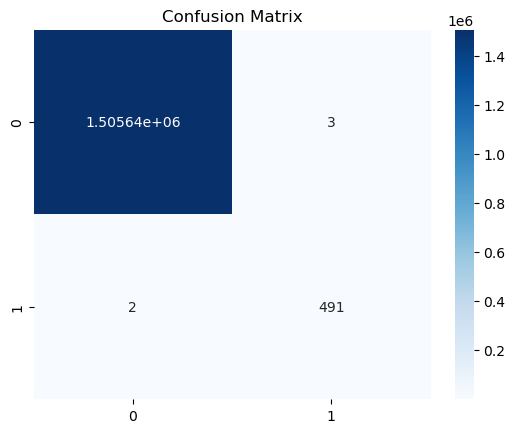

In [27]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

It gives us the overall report

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1505643
           1       0.99      1.00      0.99       493

    accuracy                           1.00   1506136
   macro avg       1.00      1.00      1.00   1506136
weighted avg       1.00      1.00      1.00   1506136



In [29]:
y_pred_proba = rfc.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC Score:', roc_auc)

ROC-AUC Score: 0.9999999919168188


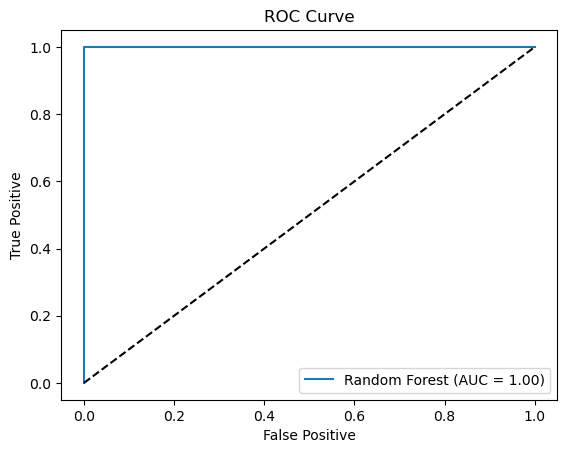

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend()
plt.show()

# key factors that predict fraudulent customer

In [31]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                importance
newbalanceOrig    0.603592
type              0.140360
oldbalanceOrg     0.110960
newbalanceDest    0.059220
amount            0.043580
oldbalanceDest    0.042288


In [35]:
df_corrected['isFraud'].value_counts()

0    6022514
1       2028
Name: isFraud, dtype: int64

# Saving the Model into a Pickle File

In [38]:
import pickle
with open('fraud_detection_model.pkl', 'wb') as file:
    pickle.dump(rfc, file)

# Loading the Model from the Pickle File

In [39]:
with open('fraud_detection_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
    
y_pred_loaded = loaded_model.predict(X_test)

# Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make sense because,
1. Transaction Amount: Larger amounts are often linked to fraud, especially in cash-outs and transfers.
2. Balance Changes: Sharp decreases in balances or sudden inflows can indicate fraudulent activity.
3. Transaction Type: High-risk types like TRANSFER and CASH-OUT are commonly used in fraud.

# What kind of prevention should be adopted while company update its infrastructure?

1. Real-time monitoring for high-risk transactions.
2. Anomaly detection to flag unusual behaviors.
3. Threshold alerts for large amounts or balance changes.
4. Multi-factor authentication for risky transactions.
5. AI-driven fraud detection systems for proactive defense.

# Assuming these actions have been implemented, how would you determine if they work?

1. Measure reduction in fraud cases and financial losses.
2. Track false positives to avoid customer dissatisfaction.
3. Monitor fraud detection accuracy (recall and precision).
4. Gather customer feedback on flagged transactions.
5. Periodically retrain models to adapt to new fraud patterns.